<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/Asset_Selection_Based_on_Turnover_based_Liquidity_Ratios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Asset Selection Based on Turnover-based Liquidity ratios</center>
## <center><i>(with backtesting)</i></center>

In [122]:
!pip install yfinance

In [123]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option("display.precision", 3)

## Functions RCT and ILLIQ
Based on whitepaper written by <i>Author</i> we will need two formulas for this calulation.

In [124]:
def rct(prices, volume):
    import pandas as pd
    import numpy as np
    
    #Pārliecinamies, ka netiek izlaistas darba dienas
    prices = prices.asfreq('B', method='ffill')
    volume = volume.resample('B').sum()

    rctTable = pd.Series(index=prices.columns)    
    for i in prices.columns:
        """
        per - periodi, kad apgrozījums nav nulle (pretējā gadījumā būs kļūda aprēķinos)
        r - ienesīgumi periodā per
        p - cenas periodā per
        v - apgrozīums periodā per
        """
        per = prices.loc[volume[i] != 0.0, i].dropna().index
        p = prices.loc[per, i]
        v = volume.loc[per, i]
    
        rctSeries = (np.abs(v * p - v.shift(1) * p.shift(1))/(v * p)).fillna(0.)
        rctTable[i] = np.sum(rctSeries)

    return rctTable

def illiq(prices, volume):
    import numpy as np
    import pandas as pd
    
    #Pārliecinamies, ka netiek izlaistas darba dienas
    prices = prices.asfreq('B', method='ffill')
    volume = volume.resample('B').sum()

    #Aprēķinam logaritmiskos ienesīgumus
    returns = np.log(prices/prices.shift(1)).fillna(0.0).resample('B').last()
    
    #Ja ievades dati ir tabula ar vairākām akcijām, tad ņemam to vērā šeit
    if type(prices) == pd.DataFrame:
        #Izveidojam tabulu priekš ILLIQ vērtībām
        illiqTable = pd.Series(index=prices.columns)

        #Ejam cauri pa vienai kolonnai un aprēķinam ILLIQ vērtības vadoties pēc formulas
        for i in prices.columns:
            """
            per - periodi, kad nedz ienesīgumi, nedz apgrozījums ir nulle (pretējā gadījumā būs kļūda aprēķinos)
            r - ienesīgumi periodā per
            p - cenas periodā per
            v - apgrozīums periodā per
            """
            per = prices.loc[np.logical_and(prices[i] != 0.0, volume[i] != 0.0), i].dropna().index
            r = returns.loc[per, i]
            p = prices.loc[per, i]
            v = volume.loc[per, i]

            #ILLIQ aprēķins atbilstoši forulai
            illiqSeries = (np.abs(r) /(v*p)).fillna(0.)                        
            illiqTable[i] = illiq = illiqSeries.mean()
            
        return illiqTable
    #Pretējā gadījumā sagaidam, ka tiek iesniegtas cenas un apgrozījumi pandas Series formātā
    else:
        per = returns[np.logical_and(returns != 0.0, volume != 0.0)].dropna().index
        r = returns.loc[per]
        p = prices.loc[per]
        v = volume.loc[per]

        #ILLIQ aprēķins atbilstoši forulai
        illiqSeries = (np.abs(r) / (v*p)).fillna(0.)                
        illiq = illiqSeries.mean()
        
        return illiq

In [125]:
def portfolioReturn(initWeight=[], assets=[], prices=pd.DataFrame(), output='single',
                    start_date=None, end_date=None, rebal_freq=None, charting=False):
    
    prices = prices.fillna(method='bfill')
    rets = prices.pct_change().fillna(0.0)    
    
    if len(initWeight) == 0 and len(assets) != 0:
        initWeight = np.ones(len(assets))/len(assets)
    
    if start_date == None: 
        start_date = prices.index[0]
    else:
        start_date = pd.to_datetime(start_date)
    
    if end_date == None: 
        end_date = prices.index[-1];
    else:
        end_date = pd.to_datetime(end_date)
    
    dt_range = prices[np.logical_and(prices.index>=start_date,prices.index<=end_date)].index
    portfolio = pd.Series(index=dt_range).fillna(0.0)

    initPort = pd.Series(initWeight, index=assets).mul(100)
    portfW = pd.Series(initWeight, index=assets).mul(100)

    if rebal_freq != None: rebal_time = prices.resample(rebal_freq).last().index;

    for dt in dt_range:        
        portfolio[dt] = (portfolio[dt] + 1) * (rets.loc[dt, portfW.index].mul(portfW.div(portfW.sum())).sum() + 1) -1
        portfW *= rets.loc[dt, portfW.index].add(1)
        
        if rebal_freq != None:
            if time2rebal(dt, rebal_time): 
                portfW = initPort.copy()
                #print('\nRebalanced to \n', initPort.div(initPort.sum()))
                
    if charting:
        portfolio.add(1).cumprod().sub(1).plot()
        plt.show();
    
    if output == 'single':
        return portfolio.add(1).cumprod().sub(1).iloc[-1]
    elif output == 'list':
        return portfolio

def time2rebal(curDate, rebalDates):
    isItTime = False
    isItTime = curDate in rebalDates
    return isItTime

# Gathering data for Baltic OMX stocks
If you are offline and have the prices in files <i>'BalticPrices.csv'</i> and <i>'BalticVolume.csv'</i> then skip the below cell and continue to the next one.

In [126]:
baltics = ['AMG1L.VS','APG1L.VS','ARC1T.TL','AUG1L.VS','BAL1R.RG','BLT1T.TL',
           'BTE1R.RG','CPA1T.TL','DPK1R.RG','EEG1T.TL','EFT1T.TL','ESO1L.VS',
           'GRD1R.RG','GRG1L.VS','GZE1R.RG','HAE1T.TL','HMX1R.RG','INC1L.VS',
           'INL1L.VS','INR1L.VS','IVL1L.VS','KA11R.RG','KNF1L.VS','KNR1L.VS',
           'LGD1L.VS','LHV1T.TL','LINDA.RG','LJM1R.RG','LNA1L.VS','LNR1L.VS',
           'LNS1L.VS','MDARA.RG','MRK1T.TL','NCN1T.TL','NTU1L.VS','OLF1R.RG',
           'PKG1T.TL','PRF1T.TL','PTR1L.VS','PZV1L.VS','RAR1R.RG','RJR1R.RG',
           'RKB1R.RG','RRR1R.RG','RSU1L.VS','SAB1L.VS','SAF1R.RG','SCM1R.RG',
           'SFG1T.TL','SKN1T.TL','SMA1R.RG','SNG1L.VS','TAL1T.TL','TEL1L.VS',
           'TKM1T.TL','TPD1T.TL','TSM1T.TL','TVEAT.TL','UTR1L.VS','VBL1L.VS',
           'VLP1L.VS','VSS1R.RG','ZMP1L.VS']

data = yf.download(baltics)
prices = data['Adj Close'].resample('D').mean().fillna(method='ffill')
volume = data['Volume'].resample('D').sum().fillna(0.0)

for c in prices.columns:
    if prices.loc[prices[c] <= 0.0, c].count() > 0:
        prices = prices.drop(c, axis=1)
        volume = volume.drop(c, axis=1)

baltics = prices.count()[prices.count() > 10*364].index.to_list()

prices = prices[baltics]
volume = volume[baltics]

prices.to_csv('BalticPrices.csv')
volume.to_csv('BalticVolume.csv')

pd.Series(baltics).values, len(baltics)

[*********************100%***********************]  63 of 63 completed

3 Failed downloads:
- ESO1L.VS: No data found, symbol may be delisted
- LINDA.RG: 1d data not available for startTime=-2208988800 and endTime=1608558766. Only 100 years worth of day granularity data are allowed to be fetched per request.
- LNR1L.VS: No data found, symbol may be delisted


(array(['APG1L.VS', 'ARC1T.TL', 'AUG1L.VS', 'BAL1R.RG', 'BLT1T.TL',
        'DPK1R.RG', 'GRD1R.RG', 'GRG1L.VS', 'GZE1R.RG', 'IVL1L.VS',
        'KNF1L.VS', 'KNR1L.VS', 'LNA1L.VS', 'LNS1L.VS', 'OLF1R.RG',
        'PRF1T.TL', 'PTR1L.VS', 'PZV1L.VS', 'RAR1R.RG', 'RJR1R.RG',
        'RKB1R.RG', 'RSU1L.VS', 'SAB1L.VS', 'SAF1R.RG', 'SCM1R.RG',
        'SFG1T.TL', 'SKN1T.TL', 'SMA1R.RG', 'SNG1L.VS', 'TAL1T.TL',
        'TEL1L.VS', 'TPD1T.TL', 'UTR1L.VS', 'VBL1L.VS', 'VLP1L.VS',
        'VSS1R.RG', 'ZMP1L.VS'], dtype=object), 37)

In [127]:
prices = pd.read_csv('BalticPrices.csv', parse_dates=['Date'], index_col='Date').resample('D').last()
volume = pd.read_csv('BalticVolume.csv', parse_dates=['Date'], index_col='Date').resample('D').sum()

prices = prices[prices.count()[prices.count()/252 >= 0.9].index].fillna(method='ffill')
baltics = prices.columns.to_list()
print(baltics)

balticLiquidity = pd.DataFrame(index=baltics)
balticLiquidity['ILLIQ'] = illiq(prices, volume)
balticLiquidity['RCT'] = rct(prices, volume)

balticLiquidity.sort_values(by='RCT').tail(15)

['APG1L.VS', 'ARC1T.TL', 'AUG1L.VS', 'BAL1R.RG', 'BLT1T.TL', 'DPK1R.RG', 'GRD1R.RG', 'GRG1L.VS', 'GZE1R.RG', 'IVL1L.VS', 'KNF1L.VS', 'KNR1L.VS', 'LNA1L.VS', 'LNS1L.VS', 'OLF1R.RG', 'PRF1T.TL', 'PTR1L.VS', 'PZV1L.VS', 'RAR1R.RG', 'RJR1R.RG', 'RKB1R.RG', 'RSU1L.VS', 'SAB1L.VS', 'SAF1R.RG', 'SCM1R.RG', 'SFG1T.TL', 'SKN1T.TL', 'SMA1R.RG', 'SNG1L.VS', 'TAL1T.TL', 'TEL1L.VS', 'TPD1T.TL', 'UTR1L.VS', 'VBL1L.VS', 'VLP1L.VS', 'VSS1R.RG', 'ZMP1L.VS']


,ILLIQ,RCT
ZMP1L.VS,5.398e-05,57666.939
KNF1L.VS,1.015e-05,59994.465
SAB1L.VS,3.355e-06,62247.968
GZE1R.RG,8.082e-05,66133.924
DPK1R.RG,2.362e-03,79899.183
LNA1L.VS,5.006e-05,85437.607
RKB1R.RG,1.034e-03,107497.934
GRD1R.RG,3.707e-04,108613.567
VSS1R.RG,2.408e-04,116899.358
RJR1R.RG,1.519e-02,116904.858


# Backtesting

## Bactesting and plots

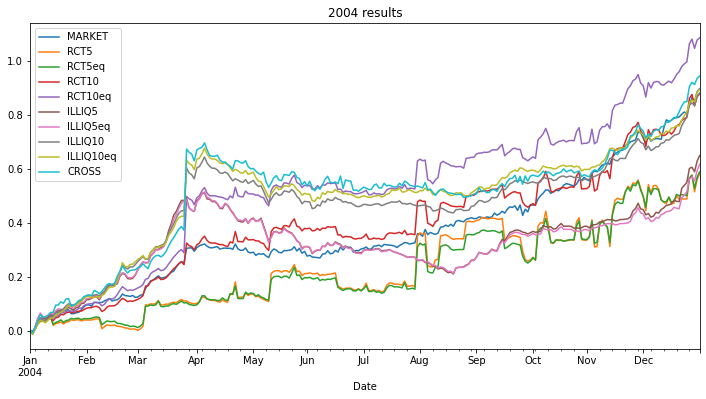

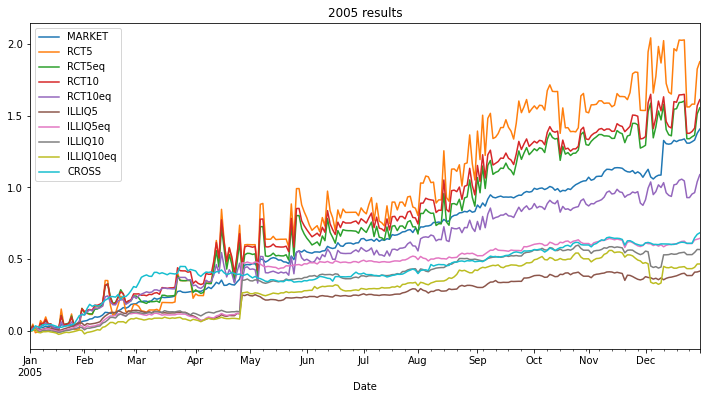

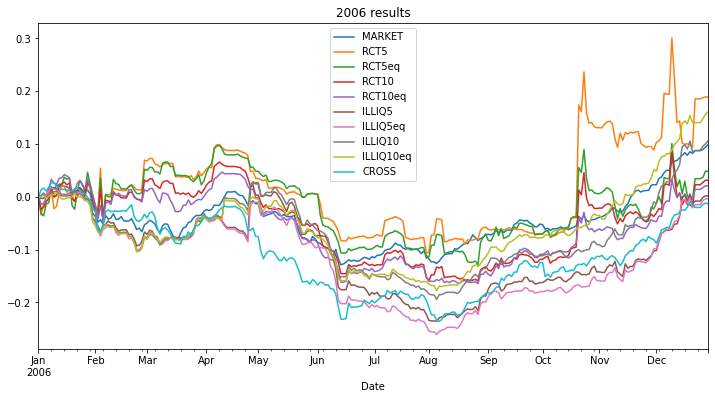

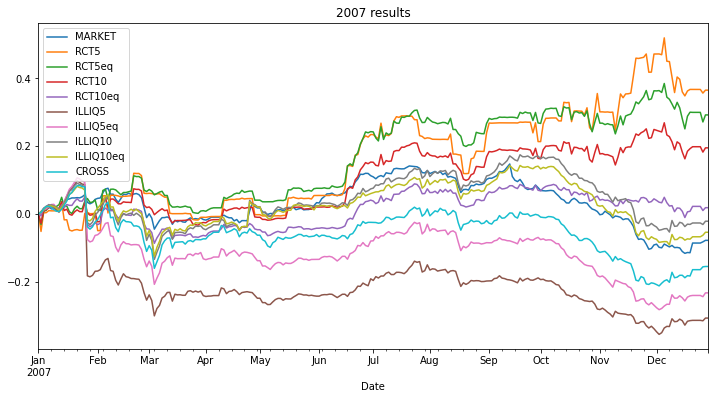

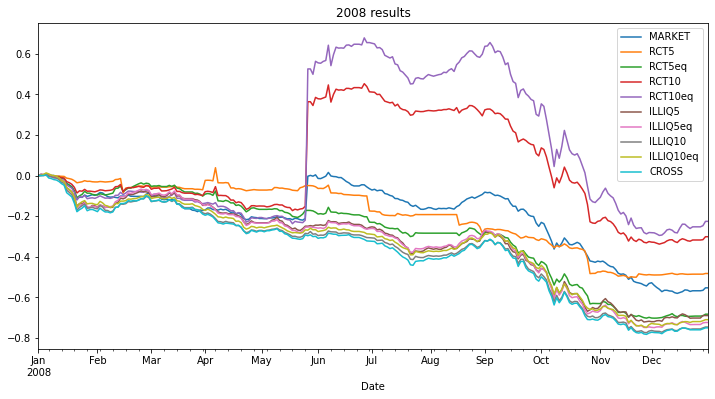

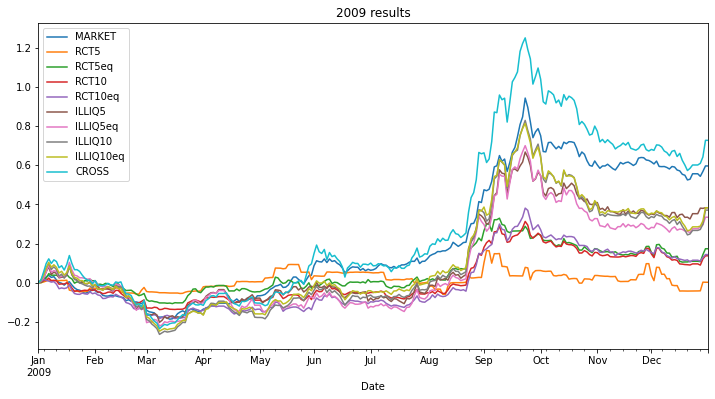

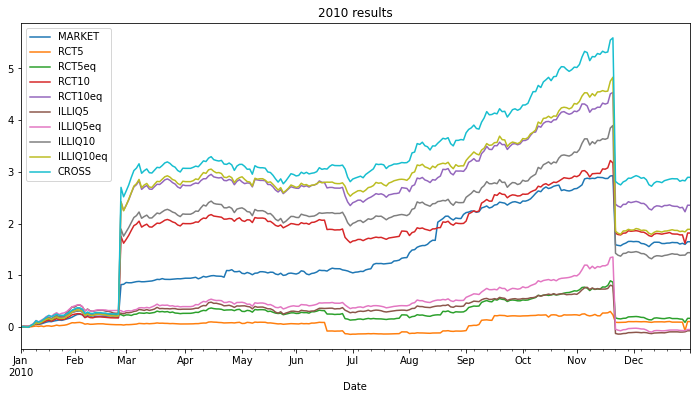

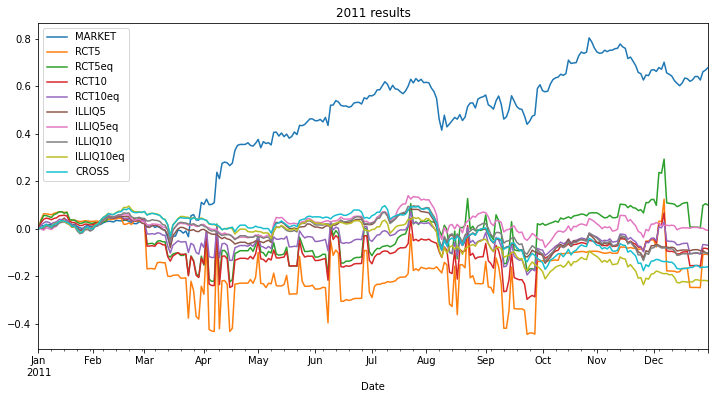

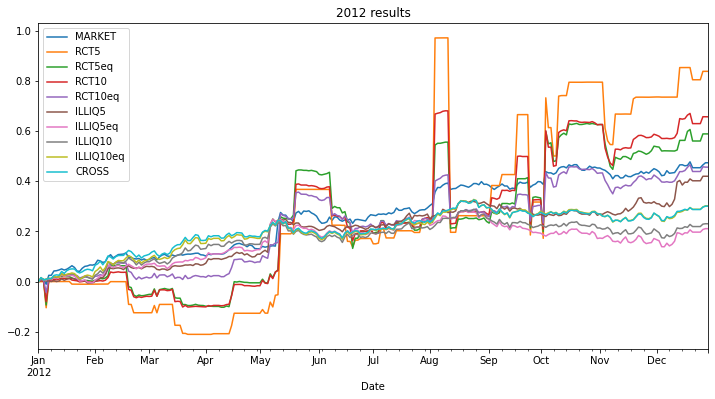

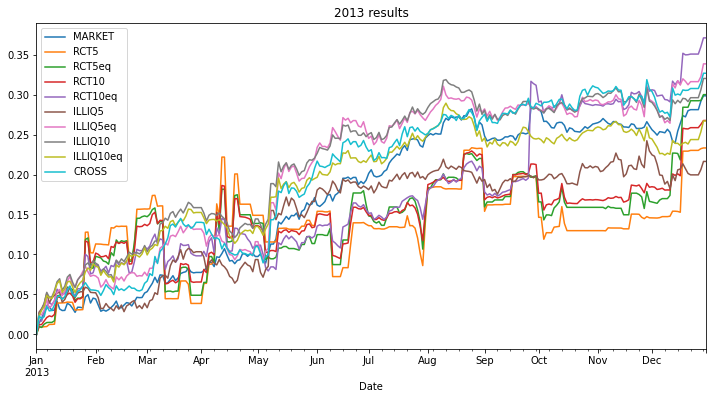

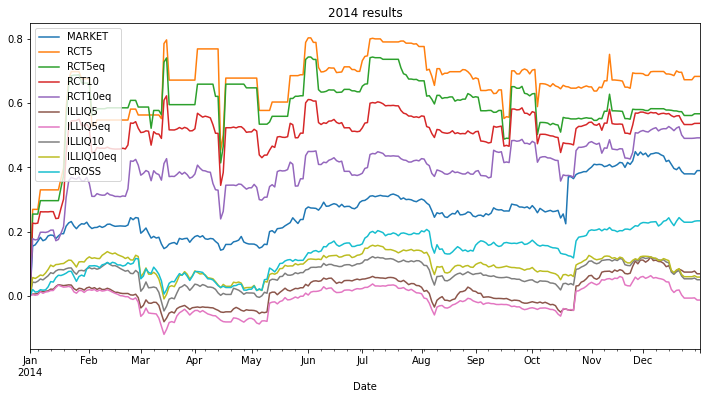

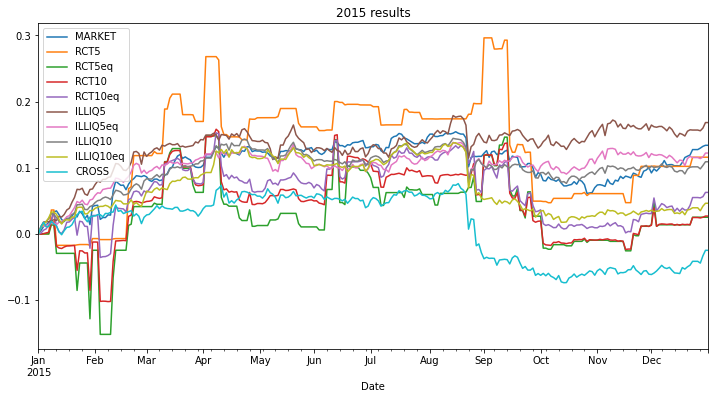

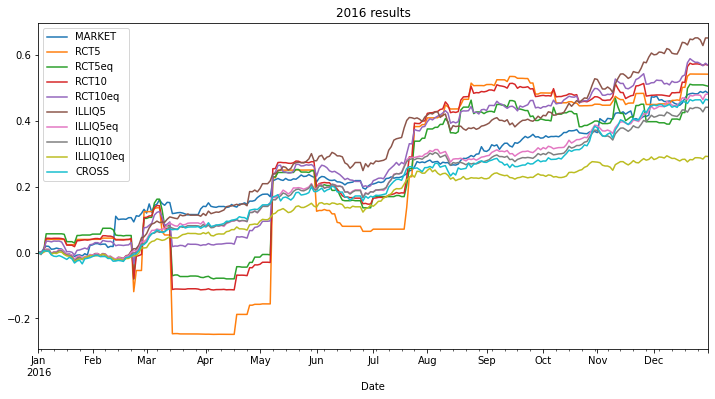

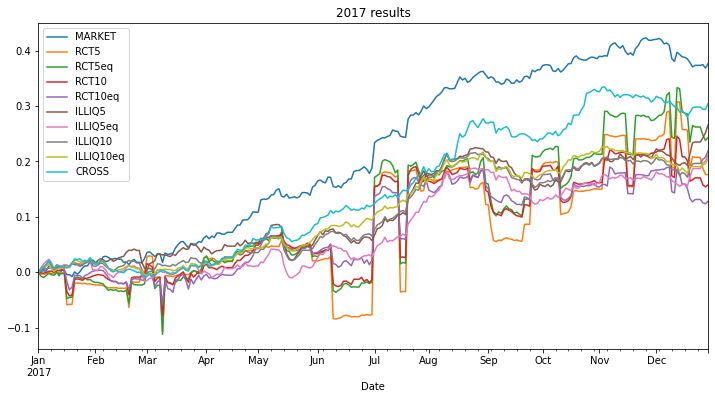

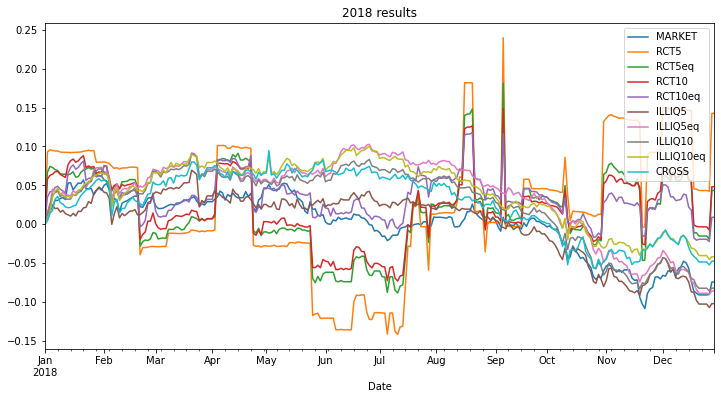

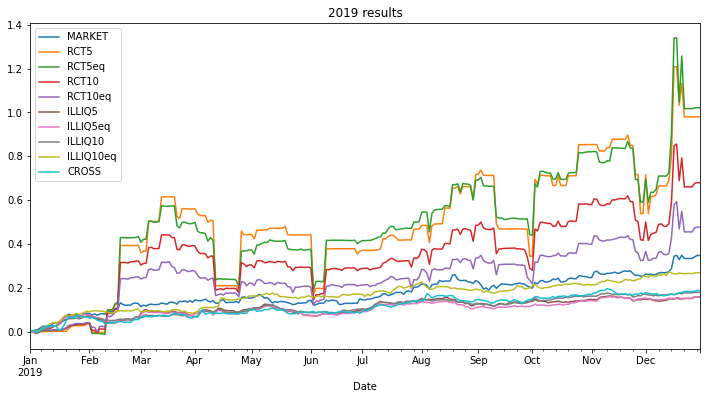

In [128]:
backtest = pd.DataFrame(columns=list(['MARKET',
                                      'RCT5','ILLIQ5','RCT10','ILLIQ10','CROSS',
                                      'RCT5eq','ILLIQ5eq','RCT10eq','ILLIQ10eq',
                                      'RCT5 Excess','ILLIQ5 Excess','RCT10 Excess',
                                      'ILLIQ10 Excess', 'RCT5eq Excess','ILLIQ5eq Excess',
                                      'RCT10eq Excess', 'ILLIQ10eq Excess','CROSS Excess',
                                      'MARKET Vol','RCT5 Vol','ILLIQ5 Vol','RCT10 Vol',
                                      'ILLIQ10 Vol','CROSS Vol']),
                        dtype=float)

for y in range(2004,2020):
    histPer = str(y-1)
    y = str(y)
    
    pp = prices.loc[y]
    pp = pp.asfreq(freq='B', method='ffill')
    
    hp = prices.loc[histPer]    
    hp = hp.asfreq(freq='B', method='ffill')    
    hp = hp[hp.count()[hp.count() > 240].index]
    
    pp = pp.asfreq(freq='B', method='ffill')    
    pp = pp[hp.columns]
    
    vv = volume.loc[histPer, hp.columns]
    vv = vv.asfreq(freq='B').fillna(0.0)
    
    rctVal = rct(hp, vv)
    illiqVal = illiq(hp, vv)    
    
    # Portfolio selections
    rctPort5 = rctVal.sort_values().index[:5]
    illiqPort5 = illiqVal.sort_values().index[:5]
    
    rctPort10 = rctVal.sort_values().index[:10]
    illiqPort10 = illiqVal.sort_values().index[:10]
    
    rctPort15 = rctVal.sort_values().index[:15]
    illiqPort15 = illiqVal.sort_values().index[:15]
    
    returns = pp.pct_change().fillna(0.0)
    
    # Portfolio allocations
    rctW5 = rctVal.loc[rctPort5]
    illiqW5 = illiqVal.loc[illiqPort5]
    rctW10 = rctVal.loc[rctPort10]
    illiqW10 = illiqVal.loc[illiqPort10]
    rctW15 = rctVal.loc[rctPort15]
    illiqW15 = illiqVal.loc[illiqPort15]
    
    rctW5 = rctW5.max() - rctW5 + rctW5.min()
    illiqW5 = illiqW5.max() - illiqW5 + illiqW5.min()
    rctW10 = rctW10.max() - rctW10 + rctW10.min()
    illiqW10 = illiqW10.max() - illiqW10 + illiqW10.min()
    rctW15 = rctW15.max() - rctW15 + rctW15.min()
    illiqW15 = illiqW15.max() - illiqW15 + illiqW15.min()
    
    rctW5 = rctW5/rctW5.sum()
    illiqW5 = illiqW5/illiqW5.sum()
    rctW10 = rctW10/rctW10.sum()
    illiqW10 = illiqW10/illiqW10.sum()
    rctW15 = rctW15/rctW15.sum()
    illiqW15 = illiqW15/illiqW15.sum()
    
    #Cumulative return table
    stDt = pp[y].index[0]
    enDt = pp[y].index[-1]

    plotTable = pd.DataFrame()
    plotTable['MARKET'] = np.cumprod(1 + returns.mean(axis=1)) - 1
    plotTable['RCT5'] = np.cumprod(1 + portfolioReturn(initWeight=rctW5, assets=rctPort5, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1
    plotTable['RCT5eq'] = np.cumprod(1 + portfolioReturn(assets=rctPort5, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1    
    plotTable['RCT10'] = np.cumprod(1 + portfolioReturn(initWeight=rctW10, assets=rctPort10, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1
    plotTable['RCT10eq'] = np.cumprod(1 + portfolioReturn(assets=rctPort10, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1
    plotTable['ILLIQ5'] = np.cumprod(1 + portfolioReturn(initWeight=illiqW5, assets=illiqPort5, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1  
    plotTable['ILLIQ5eq'] = np.cumprod(1 + portfolioReturn(assets=illiqPort5, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1  
    plotTable['ILLIQ10'] = np.cumprod(1 + portfolioReturn(initWeight=illiqW10, assets=illiqPort10, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1  
    plotTable['ILLIQ10eq'] = np.cumprod(1 + portfolioReturn(assets=illiqPort10, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1  
    
    crossNames = []
    for a in rctPort15:
        if a not in crossNames and a in illiqPort15: crossNames.append(a);
    for a in illiqPort15:
        if a not in crossNames and a in rctPort15: crossNames.append(a);
        
    plotTable['CROSS'] = np.cumprod(1 + portfolioReturn(assets=crossNames, prices=pp, output='list',rebal_freq='M',start_date=stDt, end_date=enDt)) - 1
    
    plotTable.plot(title= y + ' results', figsize=(12,6))
    plt.show();   
    
    backtest.loc[y,'MARKET'] = plotTable['MARKET'].iloc[-1]
    backtest.loc[y,'MARKET Vol'] = returns.mean(axis=1).std() * np.sqrt(252)
    
    for c in plotTable.drop('MARKET', axis=1).columns:
        backtest.loc[y, str(c)] = plotTable[str(c)].iloc[-1]
        backtest.loc[y, str(c) + ' Excess'] = backtest.loc[y, str(c)] - backtest.loc[y,'MARKET']
        backtest.loc[y, str(c) + ' Vol'] = plotTable[str(c)].std() * np.sqrt(252)

backtest.to_csv('backtest.csv', sep=';', decimal=',')

## Backtesting results summary

In [129]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print('\nHow often selection beats market (%):')
    print(pd.Series(100*backtest[backtest > 0.0].count()/backtest.count(),
                    index=list(['RCT5 Excess','ILLIQ5 Excess','RCT10 Excess',
                                'ILLIQ10 Excess','RCT5eq Excess','ILLIQ5eq Excess',
                                'RCT10eq Excess','ILLIQ10eq Excess',
                                'CROSS Excess'])).sort_values(ascending=False))

    print('\nHow often selection grew (vs stagnated or shrunk) (%):')
    print(pd.Series(100*backtest[backtest > 0.0].count()/backtest.count(),
                   index=list(['MARKET','RCT5','ILLIQ5','RCT10','ILLIQ10','CROSS',
                               'RCT5eq','ILLIQ5eq','RCT10eq','ILLIQ10eq'])).sort_values(ascending=False))

    print('\nAnnualized performance:')
    print((backtest[['MARKET','RCT5','ILLIQ5','RCT10','ILLIQ10','CROSS',
                     'RCT5eq','ILLIQ5eq','RCT10eq','ILLIQ10eq']].add(1).cumprod().iloc[-1]**(1/len(backtest.index))-1).fillna(0.0).sort_values(ascending=False))

    print('\nHow often selection had lower volatility than market?')
    for c in ['RCT5 Vol','ILLIQ5 Vol','RCT10 Vol','ILLIQ10 Vol','CROSS Vol','RCT5eq Vol','ILLIQ5eq Vol','RCT10eq Vol','ILLIQ10eq Vol']:
        excVol = backtest[c][backtest[c] < backtest['MARKET Vol']].count()/backtest['MARKET Vol'].count()        
        print(c, round(100 * excVol, 2), '%')
    
    print('\nAverage Beta of selection:')
    print(backtest[['RCT5 Vol','ILLIQ5 Vol','RCT10 Vol','ILLIQ10 Vol','CROSS Vol','RCT5eq Vol','ILLIQ5eq Vol','RCT10eq Vol','ILLIQ10eq Vol',
                    'MARKET Vol']].div(backtest['MARKET Vol'], axis=0).mean().drop('MARKET Vol').sort_values())



How often selection beats market (%):
RCT10eq Excess     56.25
RCT10 Excess       56.25
RCT5 Excess        56.25
RCT5eq Excess      50.00
CROSS Excess       31.25
ILLIQ10eq Excess   25.00
ILLIQ10 Excess     18.75
ILLIQ5 Excess      12.50
ILLIQ5eq Excess     6.25
dtype: float64

How often selection grew (vs stagnated or shrunk) (%):
RCT5eq      93.75
RCT10eq     87.50
RCT10       87.50
RCT5        87.50
MARKET      81.25
ILLIQ10eq   75.00
ILLIQ10     75.00
ILLIQ5      68.75
CROSS       62.50
ILLIQ5eq    56.25
dtype: float64

Annualized performance:
RCT10       0.36
MARKET      0.34
RCT10eq     0.34
RCT5        0.30
RCT5eq      0.25
CROSS       0.20
ILLIQ10eq   0.15
ILLIQ10     0.15
ILLIQ5      0.06
ILLIQ5eq    0.06
Name: 2019, dtype: float64

How often selection had lower volatility than market?
RCT5 Vol 0.0 %
ILLIQ5 Vol 0.0 %
RCT10 Vol 0.0 %
ILLIQ10 Vol 0.0 %
CROSS Vol 0.0 %
RCT5eq Vol 0.0 %
ILLIQ5eq Vol 0.0 %
RCT10eq Vol 0.0 %
ILLIQ10eq Vol 0.0 %

Average Beta of selection:
ILLIQ5 Vo

In [130]:
print('Statistics:')
backtest.describe()

Statistics:


,MARKET,RCT5,ILLIQ5,RCT10,ILLIQ10,CROSS,RCT5eq,ILLIQ5eq,RCT10eq,ILLIQ10eq,RCT5 Excess,ILLIQ5 Excess,RCT10 Excess,ILLIQ10 Excess,RCT5eq Excess,ILLIQ5eq Excess,RCT10eq Excess,ILLIQ10eq Excess,CROSS Excess,MARKET Vol,RCT5 Vol,ILLIQ5 Vol,RCT10 Vol,ILLIQ10 Vol,CROSS Vol,RCT5eq Vol,RCT10eq Vol,ILLIQ5eq Vol,ILLIQ10eq Vol
count,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000,16.000
mean,0.445,0.390,0.133,0.452,0.247,0.370,0.346,0.125,0.436,0.263,-0.055,-0.313,0.006,-0.198,-0.099,-0.320,-0.009,-0.182,-0.076,0.191,2.705,1.725,3.018,2.500,3.170,2.435,3.095,1.820,2.775
std,0.545,0.541,0.350,0.587,0.473,0.787,0.489,0.339,0.638,0.552,0.551,0.474,0.289,0.266,0.474,0.432,0.330,0.317,0.438,0.146,2.219,1.110,3.109,3.464,5.123,1.696,4.235,1.357,4.466
min,-0.552,-0.482,-0.689,-0.301,-0.745,-0.749,-0.682,-0.723,-0.225,-0.709,-1.545,-1.723,-0.764,-0.839,-1.482,-1.699,-0.749,-0.939,-0.839,0.078,0.715,0.543,0.682,0.466,0.644,0.775,0.421,0.419,0.543
25%,0.125,0.113,-0.082,0.044,0.032,-0.030,0.087,-0.023,0.020,0.024,-0.229,-0.266,-0.078,-0.230,-0.177,-0.311,-0.121,-0.198,-0.163,0.101,1.296,0.790,1.181,0.836,1.032,1.314,0.975,0.769,0.996
50%,0.383,0.211,0.164,0.231,0.199,0.267,0.268,0.140,0.257,0.236,0.064,-0.163,0.103,-0.163,-0.024,-0.180,0.078,-0.122,-0.095,0.139,1.881,1.314,1.670,1.203,1.377,1.854,1.655,1.232,1.336
75%,0.617,0.607,0.392,0.663,0.388,0.519,0.572,0.336,0.511,0.322,0.311,-0.075,0.189,-0.014,0.125,-0.080,0.109,0.004,0.027,0.227,3.036,2.261,3.660,2.965,2.725,3.118,3.364,2.617,2.912
max,1.648,1.876,0.652,1.816,1.436,2.894,1.555,0.645,2.354,1.888,0.632,0.167,0.332,0.057,0.674,0.040,0.706,0.240,1.246,0.661,9.357,3.749,12.564,14.746,21.591,7.335,17.934,4.801,19.019


In [131]:
print('Historical returns:')
print(backtest[['MARKET','RCT5','RCT5eq','RCT10','RCT10eq','ILLIQ5','ILLIQ5eq','ILLIQ10','ILLIQ10eq','CROSS']].mean())
backtest[['MARKET','RCT5','RCT5eq','RCT10','RCT10eq','ILLIQ5','ILLIQ5eq','ILLIQ10','ILLIQ10eq','CROSS']]

Historical returns:
MARKET       0.445
RCT5         0.390
RCT5eq       0.346
RCT10        0.452
RCT10eq      0.436
ILLIQ5       0.133
ILLIQ5eq     0.125
ILLIQ10      0.247
ILLIQ10eq    0.263
CROSS        0.370
dtype: float64


,MARKET,RCT5,RCT5eq,RCT10,RCT10eq,ILLIQ5,ILLIQ5eq,ILLIQ10,ILLIQ10eq,CROSS
2004,0.897,0.582,0.589,0.878,1.086,0.650,0.617,0.882,0.895,0.944
2005,1.406,1.876,1.555,1.612,1.089,0.418,0.645,0.568,0.467,0.684
2006,0.099,0.189,0.048,0.031,0.021,0.001,-0.004,0.106,0.162,-0.013
2007,-0.078,0.365,0.292,0.195,0.018,-0.308,-0.233,-0.022,-0.054,-0.155
2008,-0.552,-0.482,-0.682,-0.301,-0.225,-0.689,-0.723,-0.745,-0.709,-0.749
2009,0.597,0.002,0.173,0.137,0.144,0.383,0.335,0.371,0.383,0.728
2010,1.648,0.103,0.166,1.816,2.354,-0.075,-0.051,1.436,1.888,2.894
2011,0.679,-0.109,0.100,-0.085,-0.070,-0.103,-0.007,-0.106,-0.220,-0.160
2012,0.474,0.838,0.589,0.657,0.456,0.420,0.211,0.231,0.302,0.301
2013,0.298,0.233,0.300,0.268,0.371,0.216,0.338,0.320,0.267,0.327


In [132]:
print('Historical Excess returns:')
print(backtest[['RCT5 Excess','RCT5eq Excess','RCT10 Excess','RCT10eq Excess','ILLIQ5 Excess','ILLIQ5eq Excess','ILLIQ10 Excess','ILLIQ10eq Excess','CROSS Excess']].median())
backtest[['RCT5 Excess','RCT5eq Excess','RCT10 Excess','RCT10eq Excess','ILLIQ5 Excess','ILLIQ5eq Excess','ILLIQ10 Excess','ILLIQ10eq Excess','CROSS Excess']]

Historical Excess returns:
RCT5 Excess         0.064
RCT5eq Excess      -0.024
RCT10 Excess        0.103
RCT10eq Excess      0.078
ILLIQ5 Excess      -0.163
ILLIQ5eq Excess    -0.180
ILLIQ10 Excess     -0.163
ILLIQ10eq Excess   -0.122
CROSS Excess       -0.095
dtype: float64


,RCT5 Excess,RCT5eq Excess,RCT10 Excess,RCT10eq Excess,ILLIQ5 Excess,ILLIQ5eq Excess,ILLIQ10 Excess,ILLIQ10eq Excess,CROSS Excess
2004,-0.315,-0.308,-0.019,0.188,-0.248,-0.281,-0.016,-0.003,0.047
2005,0.470,0.149,0.205,-0.317,-0.989,-0.761,-0.839,-0.939,-0.722
2006,0.090,-0.050,-0.068,-0.078,-0.097,-0.102,0.007,0.063,-0.112
2007,0.444,0.370,0.273,0.097,-0.230,-0.155,0.057,0.024,-0.077
2008,0.071,-0.130,0.252,0.327,-0.137,-0.171,-0.193,-0.157,-0.197
2009,-0.594,-0.423,-0.459,-0.453,-0.214,-0.262,-0.226,-0.214,0.131
2010,-1.545,-1.482,0.168,0.706,-1.723,-1.699,-0.212,0.240,1.246
2011,-0.787,-0.579,-0.764,-0.749,-0.782,-0.686,-0.785,-0.899,-0.839
2012,0.364,0.115,0.183,-0.017,-0.054,-0.263,-0.243,-0.172,-0.173
2013,-0.065,0.001,-0.031,0.073,-0.082,0.040,0.022,-0.031,0.028


In [133]:
print('Historical volatility:')
print(backtest[['MARKET Vol','RCT5 Vol','RCT5eq Vol','RCT10 Vol','RCT10eq Vol','ILLIQ5 Vol','ILLIQ5eq Vol','ILLIQ10 Vol','ILLIQ10eq Vol','CROSS Vol']].mean())
backtest[['MARKET Vol','RCT5 Vol','RCT5eq Vol','RCT10 Vol','RCT10eq Vol','ILLIQ5 Vol','ILLIQ5eq Vol','ILLIQ10 Vol','ILLIQ10eq Vol','CROSS Vol']]

Historical volatility:
MARKET Vol       0.191
RCT5 Vol         2.705
RCT5eq Vol       2.435
RCT10 Vol        3.018
RCT10eq Vol      3.095
ILLIQ5 Vol       1.725
ILLIQ5eq Vol     1.820
ILLIQ10 Vol      2.500
ILLIQ10eq Vol    2.775
CROSS Vol        3.170
dtype: float64


,MARKET Vol,RCT5 Vol,RCT5eq Vol,RCT10 Vol,RCT10eq Vol,ILLIQ5 Vol,ILLIQ5eq Vol,ILLIQ10 Vol,ILLIQ10eq Vol,CROSS Vol
2004,0.124,2.573,2.480,3.275,4.125,1.978,1.881,2.925,3.134,3.214
2005,0.188,9.357,7.335,7.505,4.665,1.929,3.552,3.086,2.838,2.562
2006,0.101,1.297,0.937,1.065,1.039,1.183,1.256,1.105,1.183,1.155
2007,0.133,2.346,1.920,1.443,0.763,1.370,1.207,1.111,1.000,1.009
2008,0.337,2.674,3.517,3.878,5.372,3.362,3.518,3.499,3.381,3.516
2009,0.234,0.715,1.729,1.896,2.365,3.749,3.703,4.220,4.168,6.317
2010,0.661,1.746,2.816,12.564,17.934,3.441,4.801,14.746,19.019,21.591
2011,0.285,2.012,1.440,1.220,0.785,0.819,0.593,0.851,1.444,1.214
2012,0.148,5.562,3.760,4.042,2.497,1.824,1.208,1.135,1.355,1.260
2013,0.078,0.821,0.910,0.839,1.399,1.044,1.479,1.345,1.111,1.494


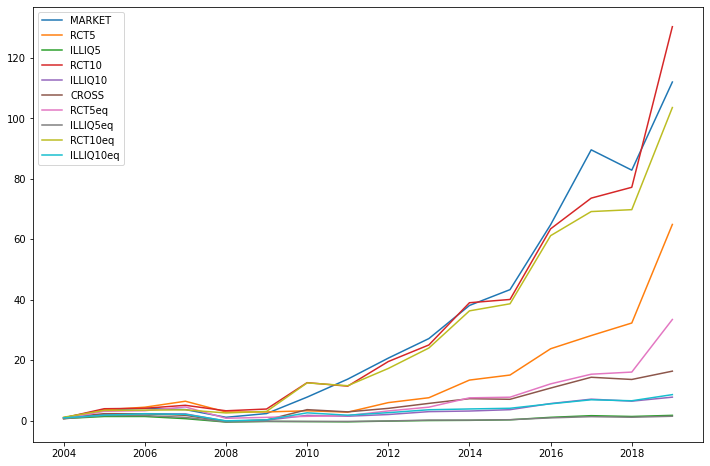

,MARKET,RCT5,ILLIQ5,RCT10,ILLIQ10,CROSS,RCT5eq,ILLIQ5eq,RCT10eq,ILLIQ10eq
2004,0.897,0.582,6.498e-01,0.878,0.882,0.944,0.589,0.617,1.086,0.895
2005,3.566,3.550,1.339e+00,3.905,1.950,2.275,3.060,1.661,3.357,1.780
2006,4.017,4.410,1.342e+00,4.056,2.262,2.232,3.256,1.651,3.447,2.229
2007,3.625,6.387,6.210e-01,5.042,2.191,1.729,4.500,1.032,3.528,2.054
2008,1.070,2.828,-4.958e-01,3.225,-0.187,-0.316,0.748,-0.437,2.509,-0.112
2009,2.305,2.836,-3.028e-01,3.805,0.114,0.182,1.052,-0.249,3.013,0.229
2010,7.752,3.230,-3.552e-01,12.533,1.715,3.602,1.391,-0.287,12.460,2.548
2011,13.693,2.770,-4.215e-01,11.384,1.427,2.866,1.630,-0.292,11.519,1.768
2012,20.654,5.930,-1.786e-01,19.519,1.987,4.029,3.178,-0.143,17.231,2.605
2013,27.117,7.547,-9.000e-04,25.011,2.944,5.673,4.431,0.148,23.995,3.567


In [134]:
backtest[['MARKET','RCT5','ILLIQ5','RCT10','ILLIQ10','CROSS','RCT5eq','ILLIQ5eq','RCT10eq','ILLIQ10eq']].add(1).cumprod().sub(1).plot(figsize=(12,8))
plt.show();
backtest[['MARKET','RCT5','ILLIQ5','RCT10','ILLIQ10','CROSS','RCT5eq','ILLIQ5eq','RCT10eq','ILLIQ10eq']].add(1).cumprod().sub(1).round(4)

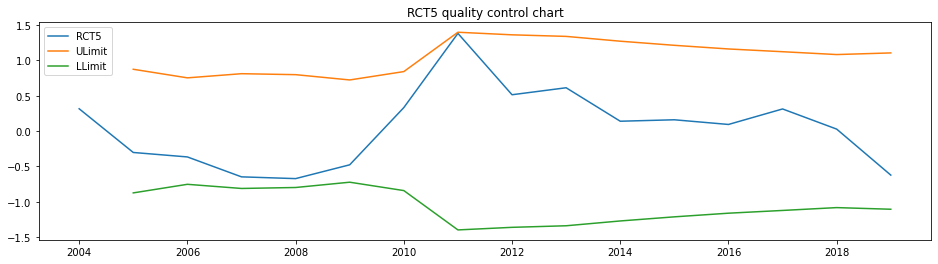

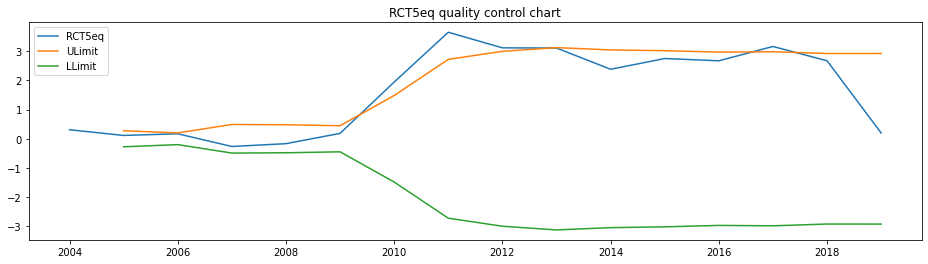

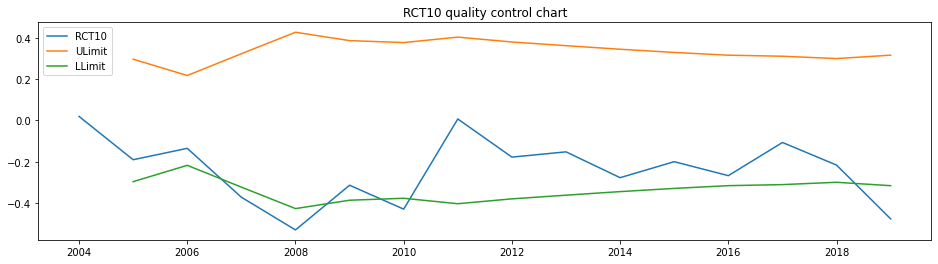

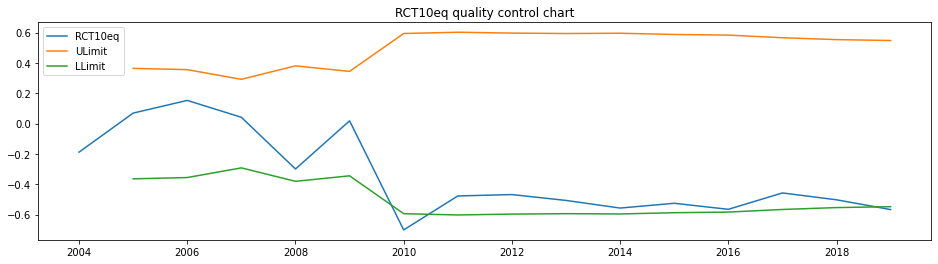

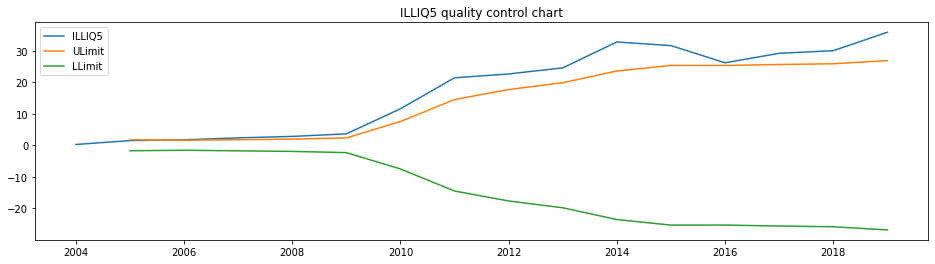

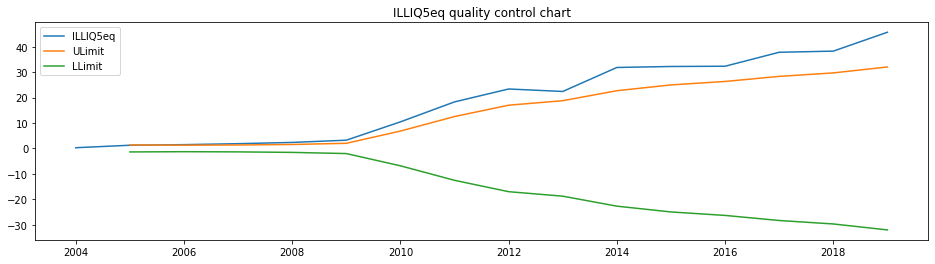

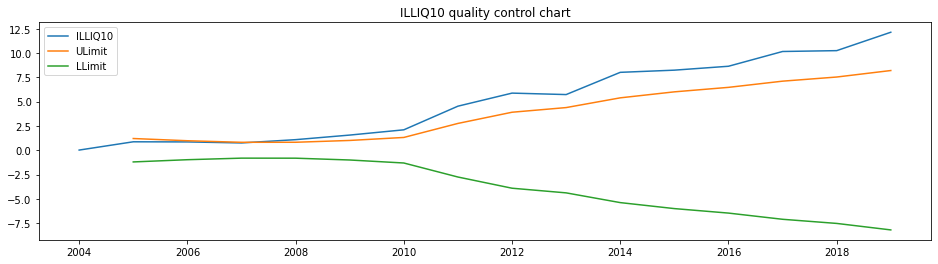

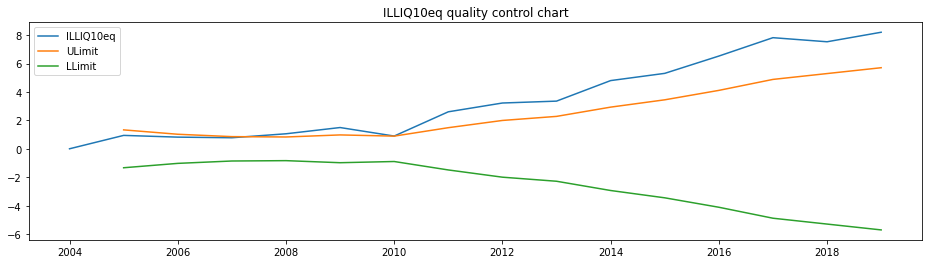

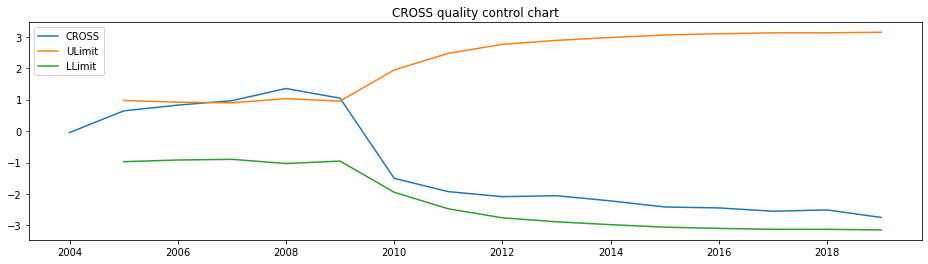

In [135]:
for c in ['RCT5','RCT5eq','RCT10','RCT10eq','ILLIQ5','ILLIQ5eq','ILLIQ10','ILLIQ10eq','CROSS']:
    temp = pd.DataFrame(index=backtest.index)
    temp['Excess'] = backtest['MARKET'].sub(backtest[c]).fillna(0.0)
    temp[c] = temp['Excess'].add(1).cumprod().sub(1)
    temp['ULimit'] = 0.0
    temp['LLimit'] = 0.0

    for dt in temp.index:
        temp.loc[dt, 'ULimit'] += temp.loc[:dt, c].std() * 2
        temp.loc[dt, 'LLimit'] -= temp.loc[:dt, c].std() * 2

    temp[[c,'ULimit','LLimit']].plot(title= str(c) + ' quality control chart',figsize=(16,4))
    plt.show();

# Current allocations

In [136]:
prices = pd.read_csv('BalticPrices.csv', parse_dates=['Date'], 
                     index_col='Date').resample('D').mean().fillna(method='ffill')
volume = pd.read_csv('BalticVolume.csv', parse_dates=['Date'], 
                     index_col='Date').resample('D').sum()

prices = prices.resample('D').last().fillna(method='ffill')

pp = prices.iloc[-366:]
pp = pp[pp.count()[pp.count() > 240].index]

vv = volume.loc[pp.index, pp.columns]

rctVal = rct(pp, vv)
illiqVal = illiq(pp, vv)

rctPort = rctVal.sort_values().index[:5]
illiqPort = illiqVal.sort_values().index[:5]

rctPortW = rctVal[rctPort].max() - rctVal[rctPort] + rctVal[rctPort].min()
illiqPortW = illiqVal[illiqPort].max() - illiqVal[illiqPort] + illiqVal[illiqPort].min()

rctPortW /= rctPortW.sum()
illiqPortW /= illiqPortW.sum()

rct10 = rctVal.sort_values().index[:10].to_list()
illiq10 = illiqVal.sort_values().index[:10].to_list() 

rct10PortW = rctVal[rct10].max() - rctVal[rct10] + rctVal[rct10].min()
illiq10PortW = illiqVal[illiq10].max() - illiqVal[illiq10] + illiqVal[illiq10].min()

rct10PortW /= rct10PortW.sum()
illiq10PortW /= illiq10PortW.sum()

rct15 = rctVal.sort_values().index[:15].to_list()
illiq15 = illiqVal.sort_values().index[:15].to_list() 
cross = []

rctPort

Index(['TAL1T.TL', 'SAB1L.VS', 'TEL1L.VS', 'SFG1T.TL', 'SMA1R.RG'], dtype='object')

In [137]:
for a in rct15:
    if a in illiq15 and a not in cross:
        cross.append(a)

for a in illiq15:
    if a in rct15 and a not in cross:
        cross.append(a)

brownies = prices.diff().dropna().div(volume.fillna(0.0)).fillna(0.0).mean()
brownies = brownies[np.logical_or(brownies>100, brownies<-100)]
brownies.index

Index(['APG1L.VS', 'AUG1L.VS', 'GRG1L.VS', 'PTR1L.VS', 'SAB1L.VS', 'TAL1T.TL',
       'TEL1L.VS'],
      dtype='object')

In [138]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print('\nCurrent RCT portfolio is:')
    print(rctPortW)
    bw = []
    for i in rctPortW.index:
        if i in brownies: bw.append(i);
    if len(bw) > 0: print('Beware these are illiquid assets:', bw);    

    print('\nCurrent ILLIQ portfolio is:')
    print(illiqPortW)
    bw = []
    for i in illiqPortW.index:
        if i in brownies: bw.append(i);
    if len(bw) > 0: print('Beware these are illiquid assets:', bw);

    print('\nCurrent RCT10 portfolio is:')
    print(rct10PortW)
    bw = []
    for i in rct10PortW.index:
        if i in brownies: bw.append(i);
    if len(bw) > 0: print('Beware these are illiquid assets:', bw);    

    print('\nCurrent ILLIQ10 portfolio is:')
    print(illiq10PortW)
    bw = []
    for i in illiq10PortW.index:
        if i in brownies: bw.append(i);
    if len(bw) > 0: print('Beware these are illiquid assets:', bw);

    print('\nCurrent CROSS picks are:')
    print(cross)

    print('\nMinimum investments per illiquid asset (EUR):')
    print(prices[brownies.index].iloc[-1] * 4)


Current RCT portfolio is:
TAL1T.TL   0.257
SAB1L.VS   0.251
TEL1L.VS   0.208
SFG1T.TL   0.148
SMA1R.RG   0.136
dtype: float64
Beware these are illiquid assets: ['TAL1T.TL', 'SAB1L.VS', 'TEL1L.VS']

Current ILLIQ portfolio is:
SAB1L.VS   0.353
TAL1T.TL   0.330
TEL1L.VS   0.241
APG1L.VS   0.054
OLF1R.RG   0.022
dtype: float64
Beware these are illiquid assets: ['SAB1L.VS', 'TAL1T.TL', 'TEL1L.VS', 'APG1L.VS']

Current RCT10 portfolio is:
TAL1T.TL   0.120
SAB1L.VS   0.120
TEL1L.VS   0.115
SFG1T.TL   0.108
SMA1R.RG   0.107
APG1L.VS   0.107
OLF1R.RG   0.105
KNF1L.VS   0.102
AUG1L.VS   0.101
VLP1L.VS   0.015
dtype: float64
Beware these are illiquid assets: ['TAL1T.TL', 'SAB1L.VS', 'TEL1L.VS', 'APG1L.VS', 'AUG1L.VS']

Current ILLIQ10 portfolio is:
SAB1L.VS   0.116
TAL1T.TL   0.115
TEL1L.VS   0.115
APG1L.VS   0.113
OLF1R.RG   0.113
SFG1T.TL   0.113
AUG1L.VS   0.110
KNF1L.VS   0.109
GRG1L.VS   0.096
GRD1R.RG   0.000
dtype: float64
Beware these are illiquid assets: ['SAB1L.VS', 'TAL1T.TL', 'TEL1L

In [140]:
print('Annual rebalancing: ', portfolioReturn(initWeight=rct10PortW.values, assets=rct10PortW.index, prices=prices, rebal_freq='A',start_date='2020-01-01', end_date='2020-12-16'))
print('Quarterly rebalancing: ', portfolioReturn(initWeight=rct10PortW.values, assets=rct10PortW.index, prices=prices, rebal_freq='Q',start_date='2020-01-01', end_date='2020-12-16'))
print('Monthly rebalancing: ', portfolioReturn(initWeight=rct10PortW.values, assets=rct10PortW.index, prices=prices, rebal_freq='M',start_date='2020-01-01', end_date='2020-12-16'))

Annual rebalancing:  -0.006343976349806879
Quarterly rebalancing:  -0.013345878723815319
Monthly rebalancing:  -0.004615846395842671
